# <center> Data Analytics and Machine Learning
***
### <center> Graphical Neural Networks
### <center>Zijie Ren & Kieran Bell

# Outline

0. An overview of PCA Analysis

1. Definitions and basics of GNN's

2. Classic architectures of GNN's with code walkthroughs for:

    - GCN's

    - GAT's

2. Advanced applications

***
# <center> 0. An overview of Principal Component Analysis (PCA)
***

## What is PCA?
 Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms a large set of variables into a smaller one that still contains most of the information in the large set.

## How PCA Works
 1. Standardize the data.
 2. Compute the covariance matrix.
 3. Calculate eigenvectors and eigenvalues.
 4. Sort eigenvalues and select top components.
 5. Project the data onto principal components.

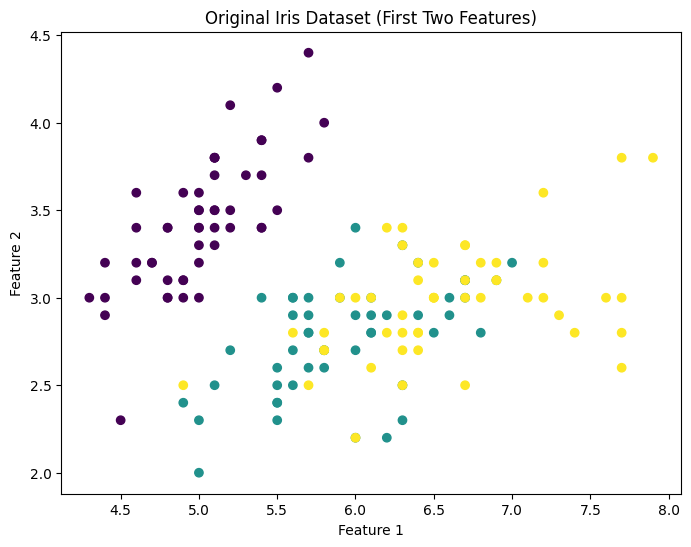

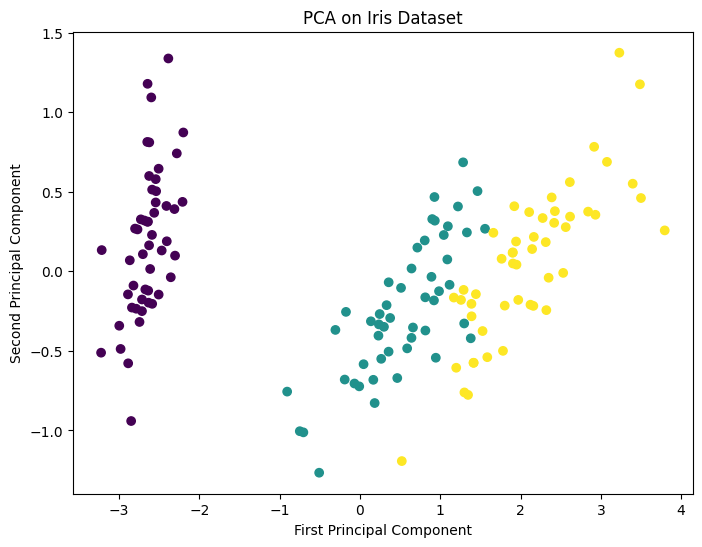

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris

# Load data
iris = load_iris()
X = iris.data
y = iris.target

# Original Data Plot (first two features)
plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Original Iris Dataset (First Two Features)')
plt.show()

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# PCA Reduced Data Plot
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA on Iris Dataset')
plt.show()

***
# <center> 1. What is a Graphical Neural Network?
***

Graph Neural Networks (GNNs) are a class of deep learning methods designed to perform inference on data described by graphs. Unlike traditional neural networks that operate on grid-like structures (e.g., images) or sequences (e.g., text), GNNs can directly process graph-structured data, making them powerful tools for relational data representation.


### 1.1 Graph structured data:

Graph structured data (often referred to as graphs) represents the relationships (edges) between different entities (nodes). A common example of information which could be stored as a graph is a social/citation network.



The structure of real-world graphs have high variability. This means the variation in the number of nodes, edges and the connectivity of the nodes is high between and within datasets.   

### 1.2 Machine Learning Tasks using Graphs:

There are three categories of tasks using graph structured data.

1. Graph Level Task - The Prediction of a single property for a whole grpah.

2. Node Level Task - The Prediction of some property for each node in a graph.

3. Edge Level Task - The Prediction of the property or presence of edges in a graph.

Each of the above tasks can be approached using a single model class the GNN.

### 1.3 The Challenges of using Graphs in Machine Learning:

Machine Learning models typically take rectangular arrays as input variables.

Does the storage of graphical data pose an issue with this?

Graphs have four types of information stored within them.

1. Nodes
2. Edges
3. Global-Context
4. Connectivity

The first three are relatively straightforward. Nodes for example form a node feature marix $N$ by assigning each node an index $i$ and storing the feature for $node_i$ in $N$.

The connectivity of a graph presents an issue. The obvious approach for inputing this into a model would be through an adjacency matrix as this is easily tensorisable.

However the adjacency matrix is rather space inefficient in cases where there is a high variability between the number of nodes and edges.

Additionally there may exist many adjacency matrices for the same connectivity. Due to the nature of neural networks there is no guarantee that they would produce the same outputs (They are not permutation invariant).

In order to avoid the inefficiency of a sparse adjacency matrix an adjacency list can be employed. This list only stores nonzero elements of the adjacency matrix making it more memory efficient and suitable for Graph Neural Networks.

#### 1.3.1 Example of Adjacency list:

Given a graph with 4 nodes and edges:

Nodes: {0, 1, 2, 3}
Edges:
- (0,1)
- (0,2)
- (1,2)
- (2,3)

The Adjacency matrix $A$ is:
$$
A=\begin{bmatrix}
0&1&1&0\\
1&0&1&0\\
1&1&0&1\\
0&0&1&0
\end{bmatrix}
$$

Each row $i$ represents node $i$ and each column $j$ represents node $j$. In the matrix a 1 represents an edge between $i$ and $j$ and a 0 means there is no edge.

To get the adjacency list we need to extract the non-zero entires. For each row $i$:

- Find all $j$ where $A[i][j]=1$
- Store those $j$-values as the neighbours of $i$.

This leaves the adjacency list:

$$
Adjacency \space List =
\begin{cases}
\begin{align*}
0: & \quad [1, 2] \space \text{(Node 0 connects to 1 and 2)}\\
1: & \quad [0, 2]\space\text{(Node 1 connects to 0 and 2)} \\
2: & \quad [0, 1, 3]\space\text{(Node 2 connects to 0, 1 and 3)} \\
3: & \quad [2]\space\text{(Node 3 connects to 2)}
\end{align*}
\end{cases}
$$

Note: Indexing starts at 0 here

This conversion works as the number of edges is expected to be much lower than the number of entries for an adjacency matrix.

The use of an adjacency list avoids the computation and storage of disconnected sections of the graph.  

Below is a python function which would perform this conversion:

In [3]:
import numpy as np

def adj_matrix_to_list(adj_matrix):
    adj_list = {}
    for i in range(len(adj_matrix)):
        adj_list[i] = []
        for j in range(len(adj_matrix[i])):
            if adj_matrix[i][j] != 0:
                adj_list[i].append(j)
    return adj_list

# Example usage
adj_matrix = [
    [0, 1, 1, 0],
    [1, 0, 1, 0],
    [1, 1, 0, 1],
    [0, 0, 1, 0]
]

adj_list = adj_matrix_to_list(adj_matrix)

# Print adjacency list
for node, neighbors in adj_list.items():
    print(f"{node}: {neighbors}")

0: [1, 2]
1: [0, 2]
2: [0, 1, 3]
3: [2]


***
# 2. The Architecture of GNN's with a practical code walkthrough
***

There has been some discussion of what exactly graphical data is and what type of problems graphical neural networks can work to solve. Now we will look at the classic structure of the GNN by using two examples. Initially we will look at the Graph Convolution Network (GCN) and develop a working node classification model utilising this structure. Following this Graph Attention Network Convolutions (GAN) will be explored with the key differences between the two architectures being summarised.

Most GNN's currently have a shared architecture similar to that of the GCN. The GCN is known to be convolutional due to the filter parameters being shared over all of the graph (or a small subset of the graph as given by [[Duvenaud et al (2015)](https://papers.nips.cc/paper_files/paper/2015/file/f9be311e65d81a9ad8150a60844bb94c-Paper.pdf)]  

GCNs perform feature transformation and information aggregation directly on nodes and their neighbors. The core operation of a GCN layer involves multiplying the node feature matrix with a normalized adjacency matrix, followed by a learnable weight matrix and non-linear activation. This enables each node to update its representation by combining its own features with those of its connected neighbors, weighted by their graph connectivity.

Nodes in a graph have varying degrees (number of connections), meaning nodes with higher degrees can disproportionately influence the learning process. Normalizing the adjacency matrix ensures that each node contributes equally to feature propagation, regardless of its degree. This prevents high-degree nodes from dominating, stabilizes training, and ensures fair influence across all nodes, making the graph convolution process more effective and balanced.

The formula to normalise the adjacency matrix is:

$\hat A = D^{-1/2} A D^{-1/2}$

Where:
- $D^{-1/2}$ is the degree matrix with inverse square roots of degrees.

GCNs are especially effective for tasks such as node classification, link prediction, and graph-level classification, where the structure of relationships is as important as the individual node attributes. The model’s ability to incorporate both feature and topological information makes it a fundamental tool in modern graph-based machine learning.




### Mathematical Formulation:

Given:
- $A$  = Adjacency matrix
- $I$ = Identity matrix (for self-loops)
- $ \widetilde{A} = A + \lambda I $ = Adjacency with weighted self-loops
- $ \hat{D}$ = Degree matrix

The GCN forward model:


$Z = f(X,A) = \text{softmax}(\hat A \ \sigma(\hat AXW^{(0)})W^{(1)})$


Where:
- $\hat A$ = Normalized adjacency matrix
- $X$ = feature vector matrix
- $W^{(l)}$ = Trainable weight matrix
- $\sigma$ = Activation function (e.g., ReLU)

---

The below code shows a simple manual implementation of the concepts covered so far with an artificially created dataset.

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn.functional as F

# ===== 1. Define the Graph =====
edges = [
    ("A", "B"),
    ("B", "A"),
    ("B", "C"),
    ("B", "D"),
    ("B", "E"),
    ("C", "B"),
    ("C", "E"),
    ("D", "B"),
    ("E", "B"),
    ("E", "C"),
    ("E", "F"),
    ("F", "E")
]

nodes = sorted(set(sum(edges, ())))  # ['A', 'B', 'C', 'D', 'E', 'F']

# ===== 2. Functions for Matrices =====

def plot_graph(edges):
    G = nx.Graph()
    G.add_edges_from(edges)

    plt.figure(figsize=(6, 6))
    nx.draw(G, with_labels=True, node_color="skyblue", node_size=2000, edge_color="gray", font_size=12, font_family="Arial")
    plt.title("Nodes Network")
    plt.show()

def get_adjacency_matrix(edges, nodes):
    adj = pd.DataFrame(0, index=nodes, columns=nodes)
    for a, b in edges:
        adj.at[a, b] = 1
    return adj

def get_degree_matrix(adj):
    deg = pd.DataFrame(0, index=adj.index, columns=adj.columns)
    for node in adj.index:
        degree = adj.loc[node].sum()
        deg.at[node, node] = degree
    return deg

def get_feature_matrix():
    features = torch.tensor([
        [1.0, 0.0],  # A
        [0.0, 1.0],  # B
        [1.0, 1.0],  # C
        [0.5, 1.5],  # D
        [1.5, 0.5],  # E
        [2.0, 1.0]   # F
    ], dtype=torch.float32)
    features_df = pd.DataFrame(features.numpy(), index=nodes, columns=["Feature1", "Feature2"])
    return features_df

# ===== 3. Calculate Basic Matrices =====

adj_matrix = get_adjacency_matrix(edges, nodes)
degree_matrix = get_degree_matrix(adj_matrix)
feature_matrix = get_feature_matrix()

print("\n--- Adjacency Matrix ---")
print(adj_matrix)

print("\n--- Degree Matrix ---")
print(degree_matrix)

print("\n--- Feature Matrix ---")
print(feature_matrix)


--- Adjacency Matrix ---
   A  B  C  D  E  F
A  0  1  0  0  0  0
B  1  0  1  1  1  0
C  0  1  0  0  1  0
D  0  1  0  0  0  0
E  0  1  1  0  0  1
F  0  0  0  0  1  0

--- Degree Matrix ---
   A  B  C  D  E  F
A  1  0  0  0  0  0
B  0  4  0  0  0  0
C  0  0  2  0  0  0
D  0  0  0  1  0  0
E  0  0  0  0  3  0
F  0  0  0  0  0  1

--- Feature Matrix ---
   Feature1  Feature2
A       1.0       0.0
B       0.0       1.0
C       1.0       1.0
D       0.5       1.5
E       1.5       0.5
F       2.0       1.0



--- Normalized Adjacency Matrix ---
     A         B         C    D         E        F
A  0.0  0.500000  0.000000  0.0  0.000000  0.00000
B  0.5  0.000000  0.353553  0.5  0.288675  0.00000
C  0.0  0.353553  0.000000  0.0  0.408248  0.00000
D  0.0  0.500000  0.000000  0.0  0.000000  0.00000
E  0.0  0.288675  0.408248  0.0  0.000000  0.57735
F  0.0  0.000000  0.000000  0.0  0.577350  0.00000

--- Weight Matrix W ---
tensor([[ 1.5410, -0.2934, -2.1788,  0.5684],
        [-1.0845, -1.3986,  0.4033,  0.8380]])

--- First GCN Layer Output (H^(1)) ---
          0         1         2         3
A -0.418568 -0.503066  0.201673  0.419013
B  1.014477 -0.888771 -0.941838  1.919198
C  0.338850 -0.616974 -0.670208  0.815440
D -0.418568 -0.503066  0.201673  0.419013
E  1.026520 -0.893627 -0.944499  1.956304
F  1.021467 -0.482040 -0.829744  0.734193


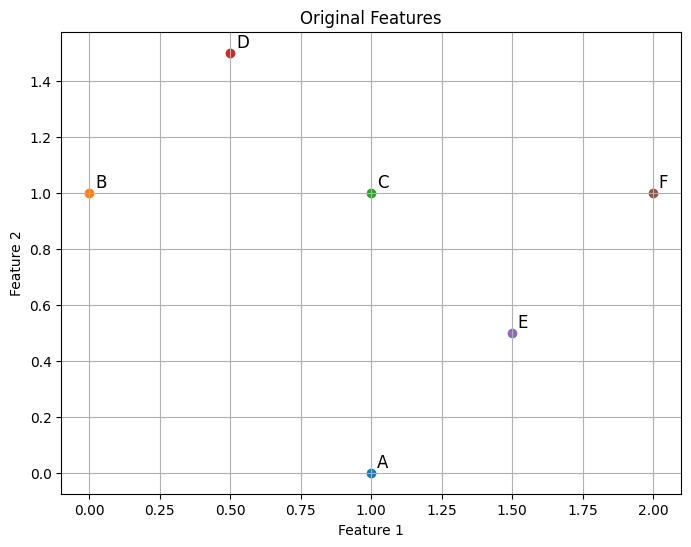

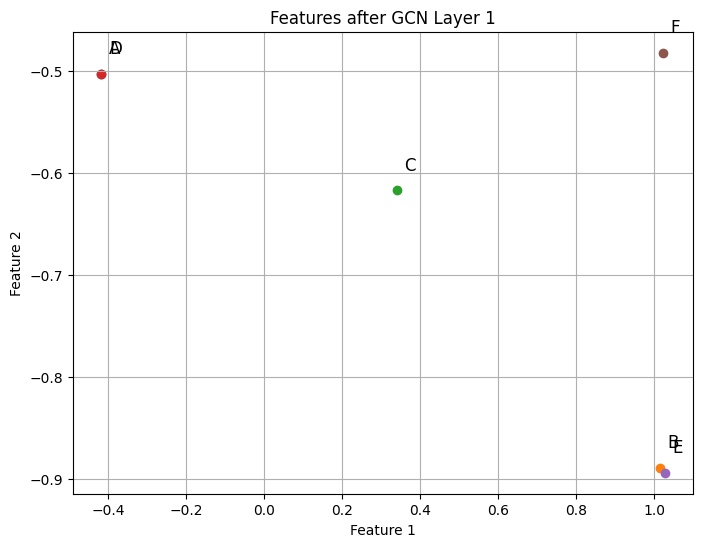

In [5]:
# ===== 4. Calculate Normalized Adjacency =====

def normalize_adjacency(adj):
    adj = torch.tensor(adj.values, dtype=torch.float32)
    deg = adj.sum(dim=1)  # Degree vector
    deg_inv_sqrt = torch.pow(deg, -0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0.0  # Handle isolated nodes
    D_inv_sqrt = torch.diag(deg_inv_sqrt)
    adj_normalized = D_inv_sqrt @ adj @ D_inv_sqrt
    return adj_normalized

norm_adj = normalize_adjacency(adj_matrix)
print("\n--- Normalized Adjacency Matrix ---")
print(pd.DataFrame(norm_adj.numpy(), index=nodes, columns=nodes))

# ===== 5. Define Weight Matrix =====

torch.manual_seed(0)  # For reproducibility
W = torch.randn((2, 4))  # (input_dim, output_dim), 2 -> 4
print("\n--- Weight Matrix W ---")
print(W)

# ===== 6. GCN Forward Step =====

X = torch.tensor(feature_matrix.values, dtype=torch.float32)
AX = norm_adj @ X
AXW = AX @ W
H1 = F.elu(AXW)

print("\n--- First GCN Layer Output (H^(1)) ---")
print(pd.DataFrame(H1.detach().numpy(), index=nodes))

# ===== 7. Visualize Feature Updates =====

def plot_features(features, title):
    features = features.detach().numpy()
    plt.figure(figsize=(8, 6))
    for i, label in enumerate(nodes):
        plt.scatter(features[i, 0], features[i, 1])
        plt.text(features[i, 0] + 0.02, features[i, 1] + 0.02, label, fontsize=12)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_features(X, "Original Features")
plot_features(H1, "Features after GCN Layer 1")

## The following code walkthrough demonstrates how to implement a GCN and a GAT to perform a Node classification task.

### Installations required to run the code:

In [6]:
!pip install -q torch

import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.3 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 84.6 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+c

In [7]:
# Libraries imported for the dataset:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

The Dataset used for the example code walkthroughs comes from the Planetoid Cora Dataset. Planetoid is a citation netowork dataset where nodes are representative of documents (each of which have 1433 dimensional bag-of-words feature vectors), edges are the citation links between documents. There are 7 classes of document within the dataset.

The aim of the following model is to be able to predict the missing class labels.

First we will extract the dataset and examine its information.

In [8]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
data = dataset[0] # Get the first graph object.
print(data)


Processing...


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Done!


We can see the dataset has:
- $2,708$ nodes
- $10,556$ edges
- $1,433$ features
- $7$ classes
The first object in the graph has $2,708$ train, validation and test masks which will be used to train and evaluate the model.

Here masks refer to a boolean array for each node which labels the nodes as belonging to either the train, validation or test sets.


### GCN Model

In order to create a nodel classification model we will use a GCN model structure which contains:
- Two GCNConv layers
- Relu activation function
- A dropout rate of $0.5$
- 16 hidden channels

The GCNConv layers are governed by:

$$
\textbf{X}_v^{(\ell+1)} = \textbf{W}^{(\ell+1)}\sum_{w\in\mathbf{\mathcal{N}}(v)\cup\left\{v\right\}}\frac{1}{c_{w,v}}\cdot\textbf{X}_w^{(\ell)}
$$

Where:

- The $W^{(\ell+1)}$ is a trainable layer specific weight matrix
- The $c_{w,v}$ denotes a fixed normalisation coefficient for each edge ($v_w, v_v$ )

For a more robust mathematical explanation see [[Thomas N. Kipf et al. (2017)](https://arxiv.org/pdf/1609.02907)]


In [9]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
	def __init__(self, hidden_channels):
		super().__init__()
		torch.manual_seed(1234567)
		self.conv1 = GCNConv(dataset.num_features, hidden_channels)
		self.conv2 = GCNConv(hidden_channels, dataset.num_classes)


	def forward(self, x, edge_index):
		x = self.conv1(x, edge_index)
		x = x.relu()
		x = F.dropout(x, p=0.5, training=self.training)
		x = self.conv2(x, edge_index)
		return x


model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


The GCNConv layers here implement the process demonstrated in the manual implementation example from earlier with the associated weight matrix being optimised through training instead of the 'random' approach utilised before.

Next we will create a function to visualise the node embedding  using sklearn.manifold.TSNE (documentation found [here:](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)) and matplotlib.pyplot. The plot should contain a 7-dimension node embedding on a 2D scatter plot.   

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualise(h, colour):
	z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

	plt.figure(figsize=(10,10))
	plt.xticks([])
	plt.yticks([])

	plt.scatter(z[:, 0], z[:, 1], s=70, c=colour, cmap="Set2")
	plt.show()

Visualising and evaluating the untrained model using the following to visualise various nodes and categories.  

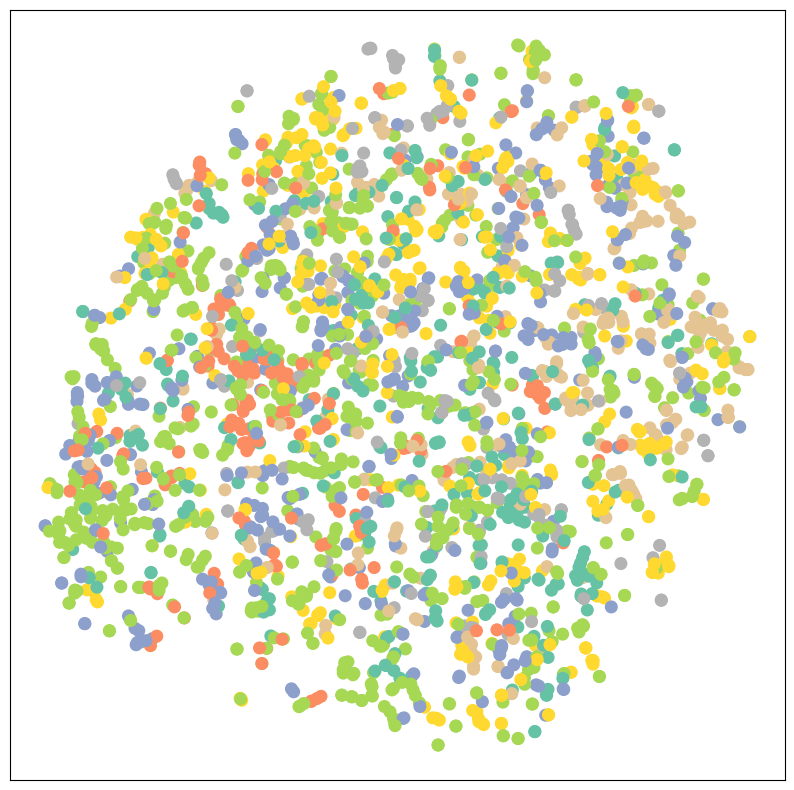

In [11]:
model.eval()

out = model(data.x, data.edge_index)
visualise(out, colour=data.y)

Training the model with the following set parameters:
- $100$ epochs
- Adam optimiser
- Cross-Entropy Loss function

The Train function created does the following:
- Clears the gradient
- Performs a single pass forward
- Computes Loss with training nodes
- Calculates the gradient and updates the parameters

The Test function created does the following:
- Predicts node class
- Extracts the class label with the highest probability
- Checks the number of correct predictions
- Creates an accuracy ratio using the sum of correct predictions divided by the total number of nodes


In [12]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
	model.train()
	optimizer.zero_grad()
	out = model(data.x, data.edge_index)
	loss = criterion(out[data.train_mask], data.y[data.train_mask])
	loss.backward()
	optimizer.step()
	return loss

def test():
	model.eval()
	out = model(data.x, data.edge_index)
	pred = out.argmax(dim=1)
	test_correct = pred[data.test_mask] == data.y[data.test_mask]
	test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
	return test_acc


for epoch in range(1, 101):
	loss = train()
print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
print(model)

Epoch: 100, Loss: 0.5799
GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


The final section of the above code prints the architecture of the GCN model is printed.

Now calling the apropriate functions to evaluate and visualise the output of the model gives:

Test Accuracy: 0.8150


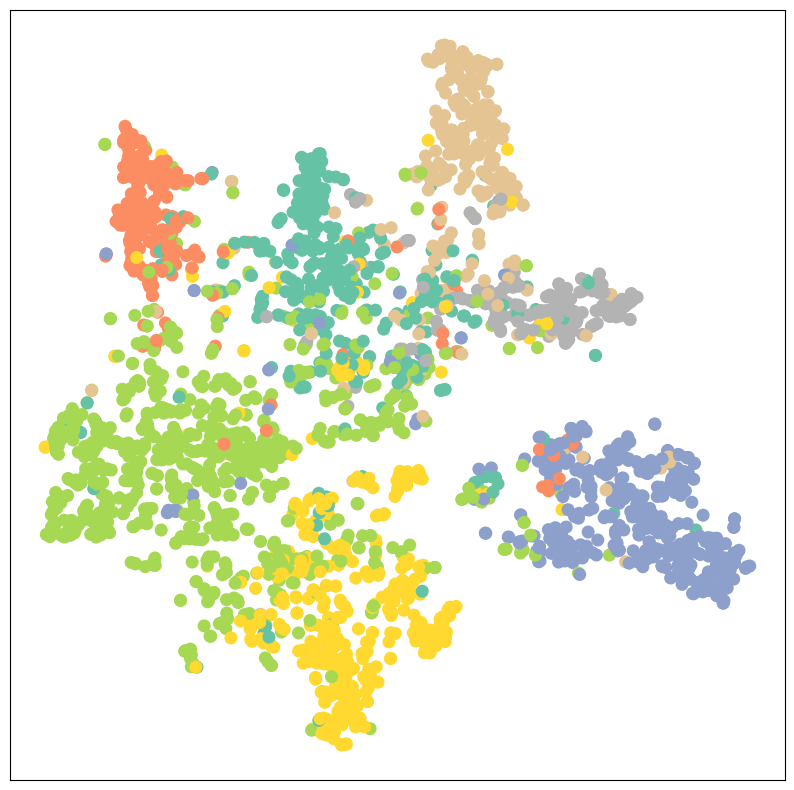

In [13]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

model.eval()
out = model(data.x, data.edge_index)
visualise(out, colour=data.y)

It can clearly be seen the trained model is much better at clustering together nodes of the same class.

#### Drawbacks of GCNConv layers:

1. GCNConv aggregates features from a node’s neighbors using a normalized sum. This means every neighbor contributes equally (up to degree normalization) regardless of their importance or relevance.
2. The convolution relies on the graph Laplacian or adjacency matrix, which can make it rigid and less adaptable to changes or noisy connections.
3. Stacking multiple GCNConv layers can cause over-smoothing, where node features become indistinguishable.
4. It's limited in its ability to differentiate between different graph structures, especially in low-degree graphs

### GAN

The architecture of GAN's follow the same basic structure as the GCN model with a few key differences.

- The GCNConv layers are replaced with GATConv layers
GAN's make use of masked self-attention layers to address the drawbacks of GCNConv layers.
- The GATConv has $8$ attention heads in the first layer and $1$ in the second layer.
- The activation function used in the forward step has been changed from relu to elu
- The dropout rate is adjusted to a value of $0.6$
- There are $8$ hidden channels
- The learning rate is set to $0.005$

The change of the activation is due to some of the subtle changes in architecture when considering GATConv models. The details of why this is the case will not be covered here but it was found empirically that the use of the elu activation worked best for GAT models. (See this paper [[Petar Velickovi ˇ c´ et al. (2017)](https://arxiv.org/pdf/1710.10903)] for a robust discussion) As such this is now considered a good default for the model. Similarly the relu activation is found to work best for GCNConv models. (See this paper [[Thomas N. Kipf et al. (2017)](https://arxiv.org/pdf/1609.02907)] for a robust discussion)


The test function is also modified in this example to find the accuracy of each specific 'mask' (validation and test) to help print validation/test scores. The Validation and Test results are also stored so that a line plot can be produced during model evaluation.

In the GATConv layers used in the example below each node has the following operation performed on it:

$$\mathbf{h}_{i}^{'}=\sigma \left( \sum_{j\in \mathcal N (i)} \alpha_{ij} \mathbf{W} \mathbf{h}_{j} \right) $$


where:
- $\mathbf{h}_{i}^{'}$ is the input feature of node i
- $\sigma$ is the activation function (to introduce non-linearity)
- $\mathbf{W}$ is a learnable linear weight matrix
- $\mathcal{N}(i)$ is the set of nodes neighbouring node i
- $\alpha_{ij}$ is the attention coefficient between nodes i and j

The Attention coefficient is calculated using the following:

$$\alpha_{ij}=\frac{\exp{\left(\text{LeakyReLU}\left(\mathbf{a}^\top [\mathbf{W} \mathbf{h}_i \, \Vert \, \mathbf{W} \mathbf{h}_j] \right)\right)}}{\sum_{k \in \mathcal{N}(i)} \exp\left(\text{LeakyReLU}\left(\mathbf{a}^\top [\mathbf{W} \mathbf{h}_i \, \Vert \, \mathbf{W} \mathbf{h}_k] \right)\right)
}$$

where:
- $\mathbf{a}$ is a learnable attention coefficient
- $\Vert \$ represents vector concatention


When comparing the GATConv and GCNConv layers the change in comlpexity in the underlying mathematics is primarily due to the use of self attention within the GATConv architecture.

In [ ]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
	def __init__(self, hidden_channels, heads):
		super().__init__()
		torch.manual_seed(1234567)
		self.conv1 = GATConv(dataset.num_features, hidden_channels, heads)
		self.conv2 = GATConv(heads*hidden_channels, dataset.num_classes, heads)

	def forward(self, x, edge_index):
		x = F.dropout(x, p=0.6, training=self.training)
		x = self.conv1(x, edge_index)
		x = F.elu(x)
		x = F.dropout(x, p=0.6, training=self.training)
		x = self.conv2(x, edge_index)
		return x

model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
	model.train()
	optimizer.zero_grad()
	out = model(data.x, data.edge_index)
	loss = criterion(out[data.train_mask], data.y[data.train_mask])
	loss.backward()
	optimizer.step()
	return loss

def test(mask):
	model.eval()
	out = model(data.x, data.edge_index)
	pred = out.argmax(dim=1)
	correct = pred[mask] == data.y[mask]
	acc = int(correct.sum()) / int(mask.sum())
	return acc

val_acc_all = []
test_acc_all = []

for epoch in range(1, 101):
	loss = train()
	val_acc = test(data.val_mask)
	test_acc = test(data.test_mask)
	val_acc_all.append(val_acc)
	test_acc_all.append(test_acc)
print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')



GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=8)
)
Epoch: 100, Loss: 1.0690, Val: 0.8060, Test: 0.8110


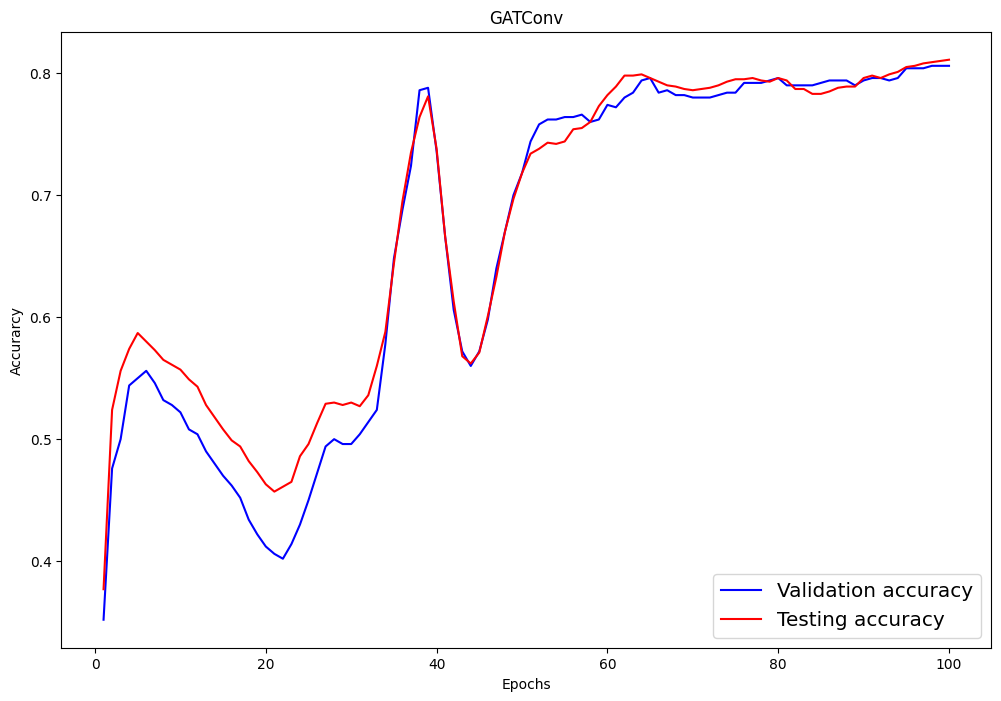

In [ ]:
import numpy as np

plt.figure(figsize=(12,8))
plt.plot(np.arange(1, len(val_acc_all) + 1), val_acc_all, label='Validation accuracy', c='blue')
plt.plot(np.arange(1, len(test_acc_all) + 1), test_acc_all, label='Testing accuracy', c='red')
plt.xlabel('Epochs')
plt.ylabel('Accurarcy')
plt.title('GATConv')
plt.legend(loc='lower right', fontsize='x-large')
plt.show()

After visualising the validation and testing scores it can be seen the GAT Model is initially fluctuating in its accuracy as it learns but eventually begins to smooth at approximately 60 Epochs to an accuracy of approximately 80%. This shows the GAT model maintains the accuracy of the GCN model in this example.

The accuracy of the two models has been seen to be comparable but is the visual representation of the nodes the same?

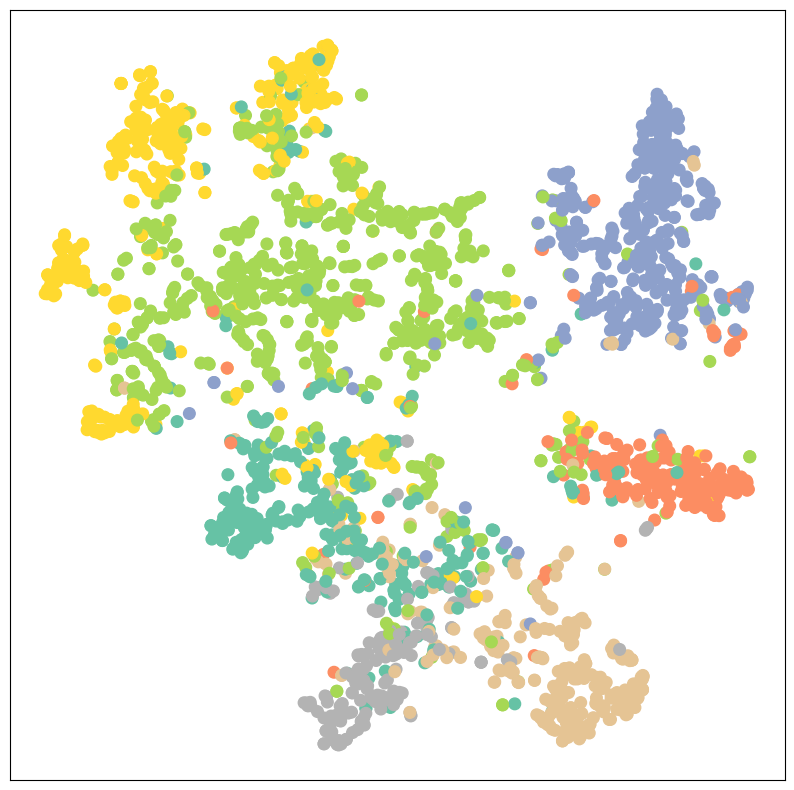

In [ ]:
model.eval()
out = model(data.x, data.edge_index)
visualise(out, colour=data.y)

It is clear that both models have produced very different visuals in order to classify the documents in the Planetoid Cora dataset. The GAT model makes a stronger distinction between the grey, orange, cyan, blue and beige coloured documents than the GCN model. However, the GCN model is much better at separating the yellow and green coloured documents indicating there may be some drawbacks to using the GATConv layers.  

#### Drawbacks of GATConv layers:
1. GATConv uses attention coefficients for each edge which increases the computational expense as the number of edges are increased.

2. This type of layer does not scale well to denser graphs (due to the number of edge computations increasing).

3. There are a higher number of hyperparameters to consider when using GATConv's increasing the risk of overfitting.

4. GATConv training is less stable due to variability of attention scores between nodes. This can lead to noisy gradients especially in early training stages.

The above code serves only as a basic example of the structure of this type of model and as such has not explored the tuning of the relevant parameters, regularisation and other common techniques which may be implemented to improve performance.

Additionally there exists many other types of layer which can be implemented and experimented with. This is an area of highly active research and this report is by no means an exhaustive overview fo the subject matter. As such it should only be regarded as an introdcution into some of the methods and principles of GNN's.


***
# Where are GNN's used in scientific research?
***

GNN'S are still a relatively new method within machine learning but they already are beginning to see practical applications in a variety of fields.


### Physics
In a paper published by [Alvaro Sanchez-Gonzalez et al. (2020)](https://proceedings.mlr.press/v119/sanchez-gonzalez20a/sanchez-gonzalez20a.pdf) GNN's are used to explore the properties and behaviours of fluids located in challenging physical domains involving rigid bodies through simulation.    

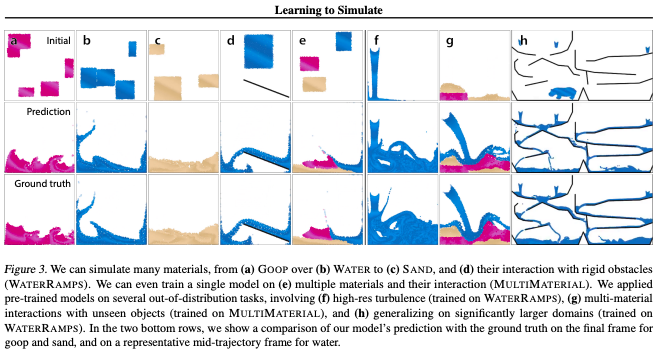


This style of problem has previously been tackled using more standard simulators which are often not best suited due to scalability becoming too computationally expensive. More standard simulations are often required to sacriice the inclusion of some of the underlying physics principles or parameters for similar reasoning. [[Alvaro Sanchez-Gonzalez et al.(2020)](https://proceedings.mlr.press/v119/sanchez-gonzalez20a/sanchez-gonzalez20a.pdf)] further found their proposed framework titled "Graph
Network-based Simulators" (GNS) produced was more accurate and had improved generalization when compared to previous modelling of fluid, rigid body and deformable material interactions.   


### Pharmacology:

Additionally there is a constant amount of research into the development of new antibiotic and antibacterial drugs. In a new approach by [Johnathon M Stokes et al. (2021)](https://pmc.ncbi.nlm.nih.gov/articles/PMC8349178/) graphical neural networks were used in order to identify molecules that inhibited the growth of E coli. This allowed [Johnathon M Stokes et al.](https://pmc.ncbi.nlm.nih.gov/articles/PMC8349178/) to produce a short list of potential compounds to further investigate from chemical libraries consisteing of $>107$ million molecules.       